In [266]:
import cv2 as cv
import numpy as np
from PIL import Image
import tempfile
import warnings
warnings.filterwarnings('ignore')

In [267]:
def set_image_dpi(file_path):       # Set image dpi for OCR engine
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def image_binarisation(img):        # Use Otsu's binarisation
    blur = cv.GaussianBlur(img,(3,3),0)
    ret,th = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def image_noise_removal(img):       # Remove noise from image
    im_nr = cv.fastNlMeansDenoising(img, 30.0, 7, 21)
    return im_nr

In [268]:
import cv2 as cv
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

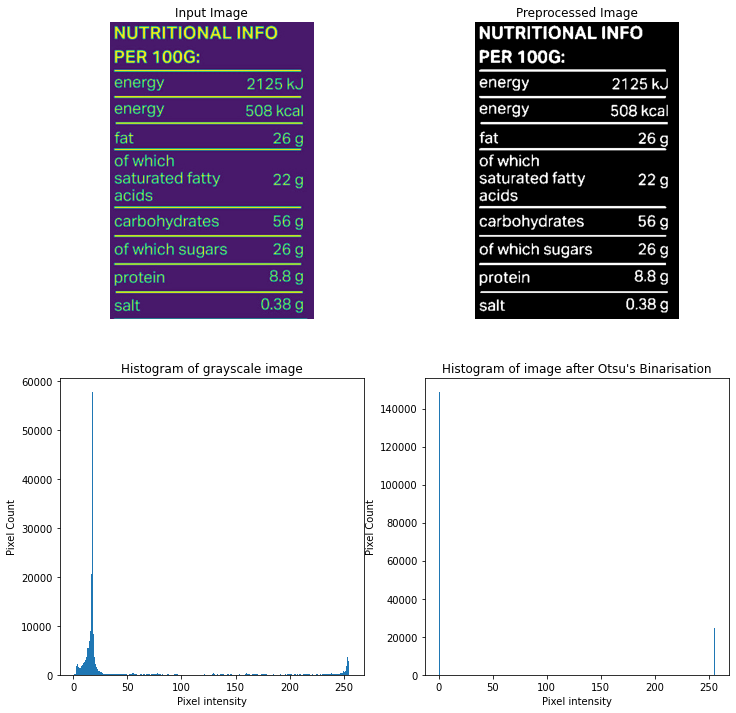

In [304]:
image_path = 'Nutritional_Facts/nf52.jpg'
img = cv.imread(image_path,0)  # read an image
img_dpi = set_image_dpi(image_path)
imgnew = cv.imread(img_dpi,0)   
img_bin = image_binarisation(imgnew)

fig = plt.figure(figsize=(12,12))
fig.add_subplot(2, 2, 1)
plt.axis("off")
plt.imshow(img)
plt.title("Input Image")
fig.add_subplot(2, 2, 2)
plt.axis("off")
plt.imshow(img_bin,'gray')
plt.title("Preprocessed Image")
fig.show()
fig.add_subplot(2, 2, 3)
plt.hist(imgnew.ravel(),256,[0,256]); 
plt.title("Histogram of grayscale image")
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Count")
fig.show()
fig.add_subplot(2, 2, 4)
plt.hist(img_bin.ravel(),256,[0,256]);
plt.title("Histogram of image after Otsu's Binarisation") 
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Count")
fig.show()


In [305]:
oem = 1
psm = 3
config = ('-l eng --oem {oem} --psm {psm}'.format(oem=oem,psm=psm))

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

food_string = pytesseract.image_to_string(img_bin,lang = 'eng',config = config)
extractedText = open("Extracted_Text.txt",'w')
extractedText.write(food_string)
extractedText.close()

In [306]:
with open('Extracted_Text.txt','r') as f:
    print(f.read())

NUTRITIONAL INFO
PER 100G:
energy 2125 kJ

energy 508 kcal
fat 26g
of which

saturated fatty 229
acids

carbohydrates 569
of which sugars 26g
protein 889g

salt 0.38 g



In [307]:
import pkg_resources
import re
from symspellpy import SymSpell, Verbosity

In [308]:
# Text parsing and nutrient data acquisition from file

with open('Extracted_Text.txt', 'r') as file :
  filedata = file.read()

# Replace and remove erroneous strings and characters from textfile
filedata = filedata.replace('Og', '0g')
filedata = filedata.replace('Omg', '0mg')
filedata = filedata.replace('Omcg', '0mcg')
filedata = filedata.replace('_', '')
filedata = filedata.replace('of which', '')
filedata = filedata.replace('Of which', '')
filedata = filedata.replace('includes', '')
filedata = filedata.replace('Includes', '')

# Write the file out again
with open('Extracted_Text.txt', 'w') as file:
  file.write(filedata)

def change_to_g(text):                              # Used to change 9 to g. ex) Protein 109 ---> Protein 10g
    search_ln = re.search("\d\s|\d$", text)
    if search_ln and search_ln.group().strip() == "9":
        index = search_ln.span()[0]
        text = text[:index] +"g"+ text[index+1:]

    search_lnq = re.search("\dmq\s|\dmq$", text)
    if search_lnq:
        index = search_lnq.span()[0] +2
        text = text[:index] +"g"+ text[index+1:]
    return text

nutrientLineList = []

with open('Extracted_Text.txt', 'r') as file:
    line_list = file.readlines()
for line in line_list:
    newline = change_to_g(line)
    search_ln = re.findall(r"(((?:\w+[ ]+)+)(\d+\.*\d*[ ]*)([a-zA-Z]+))", newline)  # Find all sentences with format: Nutrient quantity unit
    try:
        nutrientLineList.append(list(search_ln[0][1:4]))
    except:
        pass

for nutrient in nutrientLineList:
    print(nutrient)

['PER ', '100', 'G']
['energy ', '2125 ', 'kJ']
['energy ', '508 ', 'kcal']
['fat ', '26', 'g']
['saturated fatty ', '22', 'g']
['carbohydrates ', '56', 'g']
['sugars ', '26', 'g']
['protein ', '889', 'g']
['salt ', '0.38 ', 'g']


In [309]:
# Spell Checking and Correction using SymSpell

with open('nutrient.txt') as f:                 # Creates a master list of nutrients
    nutrientListMaster = f.read().splitlines()
nutrientListMaster = [word.lower() for word in nutrientListMaster]

def nutrientFinder(nutrient):                    # Checks if a given nutrient is present in the master list
    for nutrientMaster in nutrientListMaster:
        if nutrient in nutrientMaster:
            return [True,nutrientMaster]
    return [False,nutrient]

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)   # Custom list of nutrient names, which acts as the dictionary
corpus_path = "nutrient.txt"        
sym_spell.create_dictionary(corpus_path)
sym_spell.load_dictionary(corpus_path, term_index=0, count_index=1)
nutrientLineList_corrected = []

for word in nutrientLineList:           # Apply symspell spellchecking to each nutrient name
    index = nutrientLineList.index(word)
    input_term = (word[0].lower())
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)    # Find closest word in dictionary to the input
    for suggestion in suggestions:
        retVal = nutrientFinder(suggestion._term)
        if retVal[0] == True:
            nutrientLineList[index][0] = retVal[1]
            nutrientLineList_corrected.append(nutrientLineList[index])

for nutrient in nutrientLineList_corrected:
    print(nutrient)


['energy', '2125 ', 'kJ']
['energy', '508 ', 'kcal']
['fat', '26', 'g']
['saturated fatty acids', '22', 'g']
['carbohydrate', '56', 'g']
['sugars', '26', 'g']
['protein', '889', 'g']
['salt', '0.38 ', 'g']


In [310]:
import pandas as pd

NutritionTable = pd.DataFrame(columns = ["Nutrient","Quantity","Unit"]) # Create Dataframe to display nutrient list and quantity

for word in nutrientLineList_corrected:
    to_append = word
    df_length = len(NutritionTable)
    NutritionTable.loc[df_length] = to_append
    
NutritionTable.index += 1 
NutritionTable

,Nutrient,Quantity,Unit
1,energy,2125,kJ
2,energy,508,kcal
3,fat,26,g
4,saturated fatty acids,22,g
5,carbohydrate,56,g
6,sugars,26,g
7,protein,889,g
8,salt,0.38,g
